In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from questionnaire_scoring import (
    pdc_get_timepoint_1,
    process_questionnaire
    )
from data_functions import (
    convert_df_type,
    scaling, 
    pca_permulation,
    merge_dataframes,
    scaled_data,
    impute_group_median,
    determine_number_of_clusters,
    fit_pca,
    clustering

)
from factor_analysis import data_fit, create_loading_design_matrix, model_fit_parameters, cfa_model
from sklearn.cluster import KMeans
import seaborn as sns
sns.set_style('dark')

In [2]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')
banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [35]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace("TSD MDD", "MDD").str.replace('HEALTHY', '').str.lstrip()
pdc_key['src_subject_id'] = pdc_key['src_subject_id'].str.lstrip()
pdc_particpant_info = pdc_key.rename(columns={"src_subject_id": "id"})
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [79]:
ep_df = pd.read_excel(os.path.join(base_dir, 'EP', 'BehaviouralFiles.xlsx'), sheet_name=None)


In [ ]:
ep_questions = {
'depress': {"panss01": ['neg_n2', 'neg_n4', 'neg_n5','gps_g3', "gps_g6", "gps_g7", "gps_g11", "gps_g16", 'gps_g7'],
           "ymrs01": ["sleepamt", "sexinter"],
           "madrs01": ['madrssad', 'madrspes', 'madrssui', 'madrsslp', 'madrsfee', 'madrslas', 'madrscon', 'madrsapp', 'madrsaps'],
           "predd01": ['eddep04', 'eddep06', 'eddep17', 'eddep26', 'eddep29', 'eddep31', 'eddep36', 'eddep41', 'eddep54']
           },
'anxiety': {"panss01": ['gps_g2', 'gps_g4'],
           "ymrs01": ["sleepamt", "sexinter"],
           "madrs01": ["madrsten"],
           "preda01": ['idas_56', 'idas_16', 'idas_45', 'anxiety24', 'anxiety28', 'anxiety34']},
'psychosis': {
    "panss01": ['pos_p1', 'pos_p2', 'pos_p3', 'pos_p4', 'pos_p5',
       'pos_p6', 'pos_p7', 'neg_n1', 'neg_n3', 'neg_n6', 'neg_n7', 'gps_g5', 'gps_g9', 'gps_g10', 'gps_g13'],
    "ymrs01": ['langdisr']
}
}

In [ ]:
pdc_questions = {
    "depress": 
        {
            "apath01": ['apath_01', 'apath_02',
                        'apath_03', 'apath_04',
                        'apath_05', 'apath_06',
                        'apath_07', 'apath_08', 
                        'apath_09', 'apath_10',
                        'apath_11', 'apath_12', 
                        'apath_13', 'apath_14', 
                        'apath_15', 'apath_16', 
                        'apath_17', 'apath_18'],
            "shaps01": ["shaps1", "shaps2",
                        "shaps3", "shaps4",
                        "shaps5", "shaps6",
                        "shaps7", "shaps8",
                        "shaps9", "shaps10",
                        "shaps11", "shaps12",
                        "shaps13", "shaps14"],
            "hrsd01": ['hmdsd', 'happt', 'hsuic', 'hslow', 'hengy'],
            "qids01": ['vmdsd', 'vsuic', 'vengy', 'vslow', 'vapdc']

            },
    "anxiety": {
            "dass01": ['dass_1', 'dass_2',
                       'dass_4', 'dass_6',
                       'dass_7', 'dass_8',
                       'dass_9', 'dass_11',
                       'dass_12', 'dass_14',
                       'dass_15', 'dass_19',
                       'dass_20'],
            "hrsd01": ['hpanx', 'hsanx', 'hagit'],
            "qids01": ['vagit']
    },
    "psychosis": {
        "hrsd01": ['hvwsf']
    }
}

In [ ]:
banda_questions = {
'depress': {
    "rcads01": ['rcads_2', "rcads_6", 
                "rcads_11", "rcads_15", 
                "rcads_19", "rcads_21", 
                "rcads_25", "rcads_26", 
                "rcads_29", "rcads_37",
                 "rcads_40" ],
    "mfq01": ['mfqc1_1', 'mfqc1_2',
              "mfqc1_3", "mfqc1_4",
              "mfqc1_5", "mfqc1_6", 
              "mfqc2_1", "mfqc2_2",
              "mfqc2_3", "mfqc2_4",
              "mfqc2_5","mfqc2_6", 
              "mfqc3_1", "mfqc3_2",
              "mfqc3_3", "mfqc3_4",
              "mfqc3_5", "mfqc3_6",
              "mfqc4_1", "mfqc4_2",
              "mfqc4_3", "mfqc4_4",
              "mfqc4_5", "mfqc4_6",
              "mfqc5_1", "mfqc5_3",
              "mfqc5_4", "mfqc5_5",
              "mfqc6_1", "mfqc6_2",
              "mfqc6_3", "mfqc6_4"],
    "nffi01": ["nffi_6", "nffi_16", 
               "nffi_26", "nffi_41",
               "nffi_46", "nffi_51"],
    "shaps01": ["shaps1", "shaps2",
                "shaps3", "shaps4",
                "shaps5", "shaps6",
                "shaps7", "shaps8",
                "shaps9", "shaps10",
                "shaps11", "shaps12",
                "shaps13", "shaps14"],
    "cbcl01": ["cbcl35", "cbcl52", 
               "cbcl54", "cbcl76", 
               "cbcl77", "cbcl91" ],
    "stai1": ["stai20", "stai24", 
              "stai21", "stai30", 
              "stai_trait3_i", "stai_trait15_i"],
    "masq01": ['masq_04', 'masq_05', 
               'masq_06', 'masq_08', 
               'masq_09', 'masq_10',
               'masq_11', 'masq_12', 
               'masq_14', 'masq_15', 
               'masq_16', 'masq_17',
               'masq_20', 'idas_27'
               'masq_23', 'masq_24',
               'masq_29', 'idas_8', 
               'idas_40', 'pclc_9',
               'idas_50', 'idas_10',
               'atq_b_10d', 'impac_q9',
               'wn12', 'fatexp45',
               'idas_59', 'baseline_h_017',
               'stai25', 'masq90_q23',
               'masq90_q32', 'masq90_q35',
               'masq90_q71', 'masq90_q86',
               'poms038'],
    "cssrs01": ['si1l', 'si2l', 
                'sb2l', 'sb3l', 
                'sb4l', 'sb5l', 
                'sb6l', 'css_sim1',
                'css_sim2', 'sbnssibp3m',
                'sbsibiul', 'sbsibiup3m', 
                'sbiap3m','sbpabp3m', 
                'sbasiap3m', 'sb_present_interview_3m']

},

'anxiety': {
    "rcads01" : ["rcads_1", "rcads_3", 
                 "rcads_4", "rcads_5", 
                 "rcads_7", "rcads_8", 
                 "rcads_9", "rcads_10", 
                 "rcads_12", "rcads_13", 
                 "rcads_14", "rcads_16", 
                 "rcads_17", "rcads_18", 
                "rcads_20", "rcads_22", 
                "rcads_23", "rcads_24",
                "rcads_27", "rcads_28",
                "rcads_30", "rcads_31",
                "rcads_32", "rcads_33", 
                 "rcads_34",  "rcads_35",
                 "rcads_36", "rcads_38", 
                 "rcads_39", "rcads_41",
                 "rcads_42", "rcads_43", 
                 "rcads_44", "rcads_45", 
                 "rcads_46", "rcads_47"],
    "mfq01": ["mfqc5_2" ],
    "nffi01": ["nffi_1", "nffi_11", 
               "nffi_21", "nffi_31", 
               "nffi_36", "nffi_56"],
    "shaps01": [],
    "cbcl01": ["cbcl45", "cbcl29",
               "cbcl30", "cbcl31",
                "cbcl32", "cbcl45",
                 "cbcl50"],
    "stai1": ['stai1', 'stai2', 
              'stai3', 'stai5', 
              'stai6', 'stai7', 
              'stai10', 'stai11',
              'stai12', 'stai13', 
              'stai15', 'stai16', 
              'stai17', 'stai26', 
              'stai27', 'stai28', 
              'stai29', 'stai32', 
              'stai33', 'stai36', 
              'stai37', 'stai38', 
              'stai39', 'stai40', 
              'stai_state4_i', 'stai_state8_i', 
              'stai_state9_i','stai_state14_i', 
              'stai_state18_i', 'stai_state19_i', 
              'stai_trait2_i', 'stai_trait5_i',
              'stai_trait11_i', 'stai_trait14_i'],
     "masq01": ["masq_02", "masq_18", 'masq_21', 'masq_22', "masq_27", 'masq_30', "bsil38", "bsil33", "masq_nerv", "masq_dm", "masq_onedge",
                'shakyhnd', 'lumpthrt', 'bsil23', 'sweaty', 'relax', 'twitch', 'masq_afr2die', 'masq_un']

},

'psychosis': {
    "cbcl01": ["cbcl40", "cbcl68", "cbcl70", "cbcl84", "cbcl85"]
}
}

In [143]:
ep_questions['anxiety']['madrs01']

['madrsten']

In [4]:
shap_df_pdc = pdc_get_timepoint_1(pdc_df['shaps01'], pdc_particpant_info)[['id', 'phenotype', 'shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6',
       'shaps7', 'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12',
       'shaps13', 'shaps14']]
quick_depress_pdc = pdc_get_timepoint_1(pdc_df['qids01'], pdc_particpant_info)[['id', 'phenotype', 'vsoin',
       'vmnin', 'vemin', 'vhysm', 'vmdsd', 'vcntr', 'vvwsf', 'vsuic',
       'vintr', 'vengy', 'vslow', 'vagit', 'qvtot',]]
dass_pdc = pdc_get_timepoint_1(pdc_df['dass01'], pdc_particpant_info)[['id', 'phenotype' ,'dass_1',
       'dass_2', 'dass_4', 'dass_6', 'dass_7', 'dass_8', 'dass_9', 'dass_11',
       'dass_12', 'dass_14', 'dass_15', 'dass_18', 'dass_19', 'dass_20']]
depresion_scale = pdc_get_timepoint_1(pdc_df['hrsd01'], pdc_particpant_info)[['id', 'phenotype', 'hmnin', 'hemin', 'hmdsd', 'hpanx', 'hinsg', 'happt', 'hwl', 'hsanx',
       'hhypc', 'hvwsf', 'hsuic', 'hintr', 'hengy', 'hslow', 'hagit', 'hsex']]
bids = pdc_get_timepoint_1(pdc_df['bisbas01'], pdc_particpant_info)[['id', 'bissc_total', 'bas_drive', 'bas_fs', 'bas_rr']]
apathy_scale = pdc_get_timepoint_1(pdc_df['apath01'], pdc_particpant_info)[['id', 'phenotype', 'apath_01',
       'apath_02', 'apath_03', 'apath_04', 'apath_05', 'apath_06', 'apath_07',
       'apath_08', 'apath_09', 'apath_10', 'apath_11', 'apath_12', 'apath_13',
       'apath_14', 'apath_15', 'apath_16', 'apath_17', 'apath_18',]]

In [5]:
quick_depress_pdc = quick_depress_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
dass_pdc = dass_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
depresion_scale = depresion_scale.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
apathy_scale = apathy_scale.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)

In [6]:
pdc_scores = merge_dataframes([shap_df_pdc, quick_depress_pdc, dass_pdc, depresion_scale, bids, apathy_scale])

In [7]:
pdc_loadings_dict = {
    "anxiety": dass_pdc.columns[1:].to_list() + ['bissc_total'],
    "depression": quick_depress_pdc.columns[1:].to_list() + shap_df_pdc.columns[2:].to_list() + ['bas_drive', 'bas_fs', 'bas_rr',] + depresion_scale.columns[1:].to_list() + apathy_scale.columns[1:].to_list(),
    'mood': shap_df_pdc.columns[2:].to_list() + quick_depress_pdc.columns[1:].to_list() +  dass_pdc.columns[1:].to_list() + depresion_scale.columns[1:].to_list() + apathy_scale.columns[1:].to_list() + bids.columns[1:].to_list()
}
pdc_columns = pdc_loadings_dict['anxiety'] +  pdc_loadings_dict['depression']
pdc_matrix = create_loading_design_matrix(pdc_loadings_dict, pdc_columns)

In [8]:
pdc_data_fit = data_fit(convert_df_type(pdc_scores[pdc_columns]))
print(pdc_data_fit['kmo_all'])
print('bart pval', pdc_data_fit['kmo_model'])
print('kmo_model pval', pdc_data_fit['bartlett_pval'])
print('bart chi2',pdc_data_fit['bartlett_chi2'])

          KMO Score
dass_1     0.933732
dass_2     0.876582
dass_4     0.882786
dass_6     0.900798
dass_7     0.915634
...             ...
apath_14   0.931834
apath_15   0.944973
apath_16   0.925237
apath_17   0.879414
apath_18   0.946915

[79 rows x 1 columns]
bart pval 0.9153947473488518
kmo_model pval 0.0
bart chi2 18159.52515844034


<Axes: >

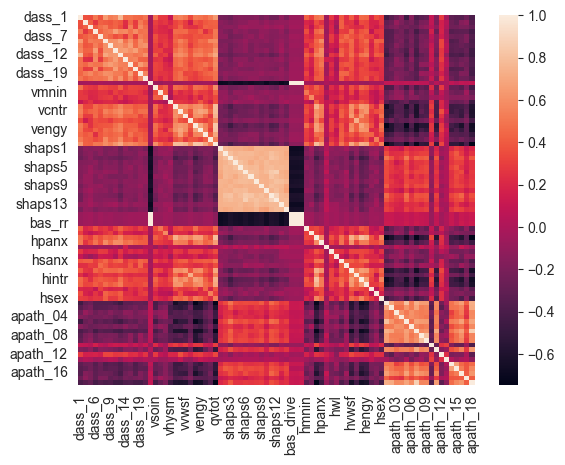

In [9]:
sns.heatmap(pdc_scores[pdc_columns].corr())

In [10]:
pdc_scaled = scaled_data(pdc_scores[pdc_columns])
pdc_model = cfa_model(pdc_matrix, pdc_scaled, 3, len(pdc_columns), [key for key in pdc_loadings_dict.keys()])

In [11]:
fit = model_fit_parameters(pdc_model, pdc_scaled, cols=pdc_columns)
display(fit['loadings'])
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,dass_1,dass_2,dass_4,dass_6,dass_7,dass_8,dass_9,dass_11,dass_12,dass_14,...,apath_09,apath_10,apath_11,apath_12,apath_13,apath_14,apath_15,apath_16,apath_17,apath_18
0,0.987242,0.919321,0.953334,1.015153,0.942174,1.031474,1.039442,1.044709,1.023898,0.973360,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.187487,0.876708,1.153691,0.869621,0.949097,1.189673,1.229576,1.206367,1.143834,1.225322
2,1.023014,0.941453,0.956280,1.000042,0.974622,1.050322,1.028351,1.044941,1.060163,0.987468,...,0.815823,1.040443,0.821711,1.127392,0.960842,0.762689,0.759275,0.772484,0.816789,0.691535


'rmse 0.00163069623198289'

'mse 2.7872498629272406e-06'

In [12]:
pdc_data = pd.concat([pdc_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(pdc_model.fit_transform(pdc_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: "mood"})], axis=1)

<Axes: >

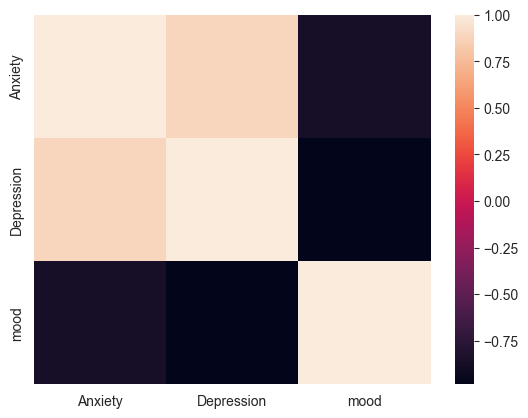

In [13]:
sns.heatmap(pdc_data[['Anxiety', 'Depression', 'mood']].corr()
)

<Axes: >

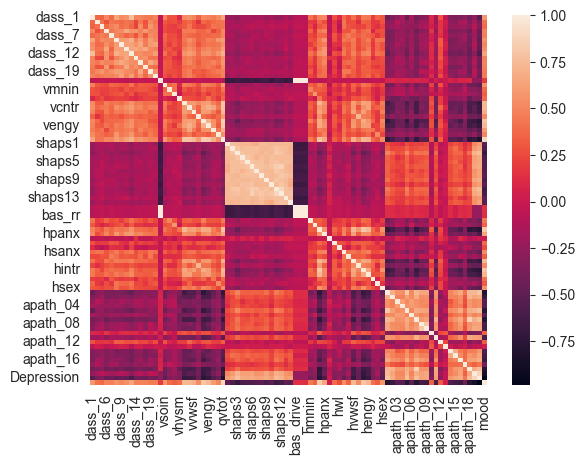

In [14]:
sns.heatmap(pd.concat([pdc_scores[pdc_columns], pdc_data[['Anxiety', 'Depression', 'mood']]], axis=1).corr()
)

## BANDA symptoms

In [15]:
sub_scores = {
    "social_phobia": [4, 7, 8, 12, 20, 30, 32, 38, 43],
    "panic_disorder": [3, 14, 24, 26, 28, 34, 36, 39, 41],
    "maj_depression": [2, 6, 11, 15, 19, 21, 25, 29, 40, 47],
    "seperation_anxiety": [5, 9, 17, 18, 33, 45, 46],
    "general_anxiety": [1, 13, 22, 27, 35, 37],
    "ocd": [10, 16, 23, 31, 42, 44]
}

rdacs_score = {
    "Never": 0,
    "Sometimes": 1,
    "Often": 2,
    "Always": 3
}
rcads01 = banda_df["rcads01"][banda_df["rcads01"]['visit'] == 'T1']
rcads01 = rcads01.drop(rcads01[rcads01['src_subject_id'].duplicated()].index)
rcads_cols = rcads01.columns[8:]
scored_df = rcads01[rcads_cols].replace(rdacs_score)
scores = dict(zip([key for key in sub_scores], [[] for key in sub_scores]))
scores['particpant'] = rcads01['src_subject_id'].loc[1:]

for sub_scal in sub_scores:
    scores[sub_scal] = scored_df.loc[:, [f"rcads_{str(index)}" for index in sub_scores[sub_scal]]].sum(axis=1)

rcads_df = pd.DataFrame(
    data = scores
)
cols = rcads_df.columns.tolist()
cols = [cols[-1]] + cols[1:-1] + [cols[0]]
cols = cols[:1] + [cols[2]] + [cols[1]] + cols[3:]
rcads_df = rcads_df[cols]

try:
    del(rcads_df['internalising'])
    del(rcads_df['anxiety'])
except Exception as e:
    pass
rcads_df['internalising'] = rcads_df.iloc[:, 1:].sum(axis=1)
rcads_df['anxiety'] = rcads_df.iloc[:, 2:7].sum(axis=1)
rcads_df = rcads_df.rename(columns={"particpant": "id"})

In [16]:
mfg_score = process_questionnaire(banda_df['mfq01'], band_particpant_info, 'mfq01_id')[['id', 'phenotype', 'mfqc1_1',
       'mfqc1_2', 'mfqc1_3', 'mfqc1_4', 'mfqc1_5', 'mfqc1_6', 'mfqc2_1',
       'mfqc2_2', 'mfqc2_3', 'mfqc2_4', 'mfqc2_5', 'mfqc2_6', 'mfqc3_1',
       'mfqc3_2', 'mfqc3_3', 'mfqc3_4', 'mfqc3_5', 'mfqc3_6', 'mfqc4_1',
       'mfqc4_2', 'mfqc4_3', 'mfqc4_4', 'mfqc4_5', 'mfqc4_6', 'mfqc5_1',
       'mfqc5_2', 'mfqc5_3', 'mfqc5_4', 'mfqc5_5', 'mfqc6_1', 'mfqc6_2',
       'mfqc6_3', 'mfqc6_4' ]]
stai01_score = process_questionnaire(  banda_df["stai01"], 
    band_particpant_info, 
    'stai01_id', )[[  'id', 'phenotype', 'stai1',
       'stai2', 'stai3', 'stai5', 'stai6', 'stai7', 'stai10', 'stai11',
       'stai12', 'stai13', 'stai15', 'stai16', 'stai17', 'stai20', 'stai21',
       'stai24', 'stai26', 'stai27', 'stai28', 'stai29', 'stai30', 'stai32',
       'stai33', 'stai36', 'stai37', 'stai38', 'stai39', 'stai40',
       'stai_state4_i', 'stai_state8_i', 'stai_state9_i', 'stai_state14_i',
       'stai_state18_i', 'stai_state19_i', 'stai_trait2_i', 'stai_trait3_i',
       'stai_trait5_i', 'stai_trait11_i', 'stai_trait14_i', 'stai_trait15_i']]
shaps_score = process_questionnaire(  banda_df["shaps01"], 
    band_particpant_info, 'shaps01_id')[[  'id', 'phenotype',     'shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6', 'shaps7',
       'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12', 'shaps13',
       'shaps14']]

In [17]:
mfg_score = mfg_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
stai01_score = stai01_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_score = shaps_score.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)

In [18]:
dfs = [stai01_score, shaps_score, mfg_score, 
       rcads_df[['id', 'social_phobia', 'panic_disorder', 'maj_depression', 'seperation_anxiety', 'general_anxiety', 'ocd']]] 
merged_df = merge_dataframes(dfs)
banda_df_scored = pd.merge(band_particpant_info, merged_df, how='outer')

In [19]:
grouping = banda_df_scored.groupby("phenotype")
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].median(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df

In [20]:
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']]).sort_values("id")

In [21]:
banda_df_scored

,id,phenotype,sex,interview_age,stai1,stai2,stai3,stai5,stai6,stai7,...,mfqc6_1,mfqc6_2,mfqc6_3,mfqc6_4,social_phobia,panic_disorder,maj_depression,seperation_anxiety,general_anxiety,ocd
0,BANDA001,Control,F,184,4.0,4.0,1.0,4.0,1.0,1.0,...,2.0,1.0,2.0,1.0,19.0,1.0,3.0,2.0,2.0,0.0
1,BANDA002,Control,F,169,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,2.0,8.0,4.0,2.0,0.0,1.0,1.0
2,BANDA003,Control,M,177,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0
3,BANDA004,Control,M,188,4.0,4.0,1.0,4.0,1.0,1.0,...,1.0,1.0,2.0,1.0,11.0,2.0,7.0,0.0,1.0,3.0
4,BANDA005,Control,M,191,4.0,3.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,3.0,4.0,3.0,3.0,2.0,2.0,...,1.0,1.0,1.0,1.0,11.0,6.0,5.0,7.0,5.0,1.0
199,BANDA211,Depression,F,196,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,2.0,2.0,2.0,15.0,9.0,16.0,3.0,9.0,2.0
200,BANDA212,Depression,F,186,3.0,3.0,3.0,3.0,4.0,4.0,...,3.0,2.0,2.0,1.0,23.0,11.0,22.0,10.0,14.0,9.0
201,BANDA213,Depression,F,184,3.0,3.0,4.0,3.0,2.0,4.0,...,3.0,3.0,3.0,1.0,27.0,15.0,23.0,14.0,8.0,5.0


In [22]:
shaps_score.columns[1:] 

Index(['shaps1', 'shaps2', 'shaps3', 'shaps4', 'shaps5', 'shaps6', 'shaps7',
       'shaps8', 'shaps9', 'shaps10', 'shaps11', 'shaps12', 'shaps13',
       'shaps14'],
      dtype='object')

In [23]:
banda_loadings_dict = {
    "anxiety": stai01_score.columns[1:].to_list() + ['social_phobia', 'panic_disorder', 'seperation_anxiety', 'general_anxiety', 'ocd'],
    "depression": mfg_score.columns[1:].to_list() + shaps_score.columns[1:].to_list() + ['maj_depression'],
    'mood': mfg_score.columns[1:].to_list() + shaps_score.columns[1:].to_list() + stai01_score.columns[1:].to_list() + ['maj_depression', 'social_phobia', 'panic_disorder', 'seperation_anxiety', 'general_anxiety', 'ocd'],
}
banda_columns = banda_loadings_dict['anxiety'] +  banda_loadings_dict['depression']
banda_matrix = create_loading_design_matrix(banda_loadings_dict, banda_columns)

In [24]:
banda_scaled = scaled_data(banda_df_scored[banda_columns])
banda_model = cfa_model(banda_matrix, banda_scaled, 3, len(banda_columns), [key for key in banda_loadings_dict.keys()])

In [25]:
fit = model_fit_parameters(banda_model, banda_scaled, cols=banda_columns)
display(fit['loadings'])
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,stai1,stai2,stai3,stai5,stai6,stai7,stai10,stai11,stai12,stai13,...,shaps6,shaps7,shaps8,shaps9,shaps10,shaps11,shaps12,shaps13,shaps14,maj_depression
0,1.154886,1.162777,0.86557,1.165758,0.924004,0.926972,1.174103,1.142112,0.907111,0.918737,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.965767,0.988067,0.952115,1.001486,0.926951,0.942019,0.998045,0.935014,0.998596,0.934544
2,0.705349,0.738365,1.18893,0.722840,1.140244,1.201347,0.702151,0.665686,1.208282,1.147496,...,0.656043,0.901450,0.633927,0.857033,0.614517,0.612225,0.867127,0.633895,0.816513,1.321442


'rmse 0.0019007058183345255'

'mse 3.8146124144887586e-06'

In [26]:
banda_data = pd.concat([banda_df_scored[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(banda_model.fit_transform(banda_df_scored[banda_df_scored.columns[4:]].values)).rename(columns={0: "Anxiety", 1:"Depression", 2:"mood"})], axis=1)

<Axes: >

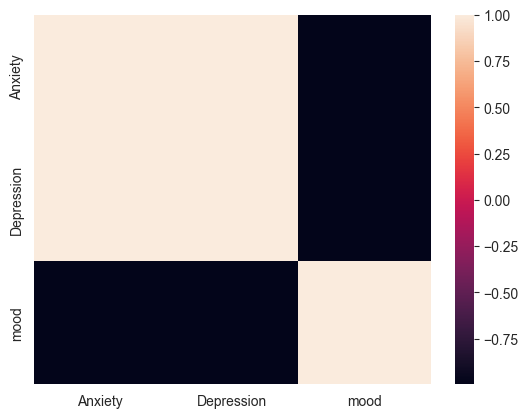

In [27]:
sns.heatmap(banda_data[["Anxiety", "Depression", "mood"]].corr())

In [28]:
clustering_df = pd.concat([banda_data, pdc_data])

In [30]:
pca_df = clustering_df[['interview_age', 'sex', 'Anxiety', 'Depression', 'mood'
      ]]
pca_df['sex'] = pca_df['sex'].apply(lambda x: 1 if x=="F" else 0)
pca_df['interview_age'] = pca_df['interview_age'].astype('float')
normalised_data = scaling(pca_df)
dat = pca_permulation(pca_df, normalised_data)
pca_dat = fit_pca(dat, normalised_data)
determine_number_of_clusters(pca_dat, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.5735065051881701
For n_clusters = 3 The average silhouette_score is : 0.5058388806552089
For n_clusters = 4 The average silhouette_score is : 0.604123736235081
For n_clusters = 5 The average silhouette_score is : 0.5736434123111703
For n_clusters = 6 The average silhouette_score is : 0.5332397794586179
For n_clusters = 7 The average silhouette_score is : 0.548702308114525
For n_clusters = 8 The average silhouette_score is : 0.5488678208018519
For n_clusters = 9 The average silhouette_score is : 0.5324435571640824
For n_clusters = 10 The average silhouette_score is : 0.536861781629421


In [31]:
clusters = clustering(4, pca_dat)
clustering_df['group'] = clusters.labels_

In [32]:
group = clustering_df.groupby("group")
numbers = group.count()['sex'].rename("Count")
phenotype = group['phenotype'].unique().rename("phenotype")
number_in_each_group = group['phenotype'].value_counts().T
pd.concat([numbers, phenotype, group[["Anxiety", "Depression"]].mean(),], axis=1)

,Count,phenotype,Anxiety,Depression
group,,,,
0,88,"[Control, Anxiety, Depression, MDD]",-2.372309,-3.148902
1,116,"[Depression, Anxiety, MDD, Control]",1.441409,2.019699
2,190,"[Control, Depression, Anxiety, MDD]",-0.342787,-0.512239
3,25,"[Depression, Anxiety]",4.267571,5.605749


In [33]:
number_in_each_group

group  phenotype 
0      Control       60
       MDD           15
       Anxiety       10
       Depression     3
1      MDD           57
       Anxiety       28
       Depression    28
       Control        3
2      MDD           94
       Control       50
       Anxiety       32
       Depression    14
3      Depression    18
       Anxiety        7
Name: count, dtype: int64

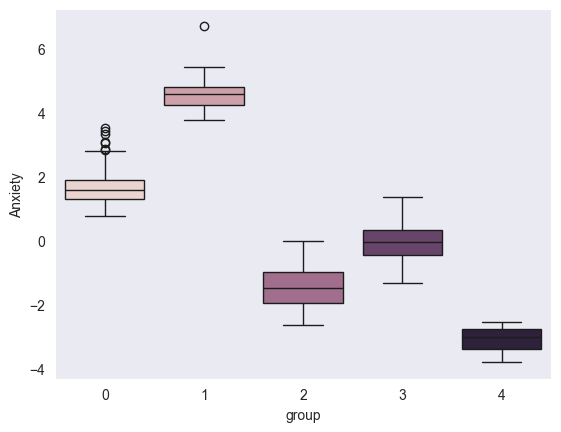

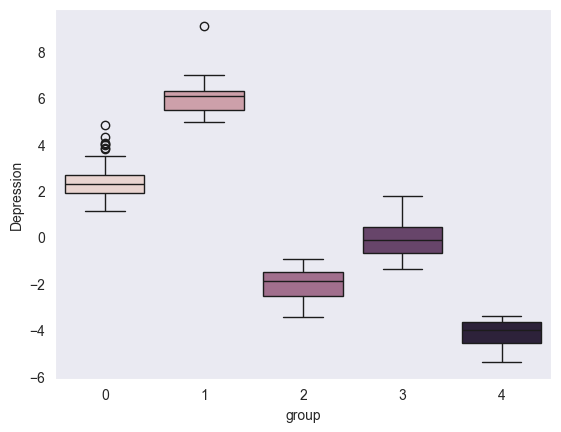

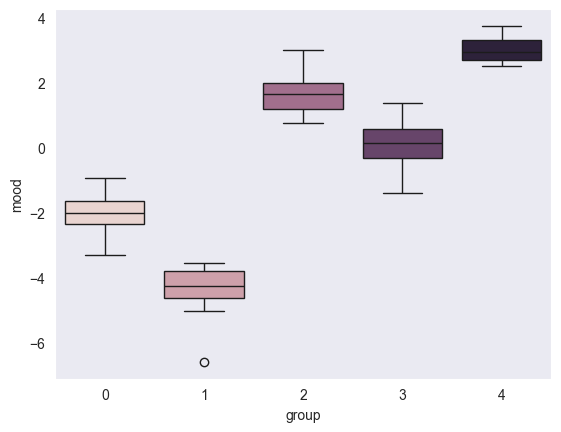

In [ ]:
for val in ['Anxiety', 'Depression','mood']:
    plot = sns.boxplot(data=clustering_df, x='group', y=val, hue='group')
    plot.get_legend().remove()
    plt.show()